In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import itertools
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size': 20, 'text.usetex': True})
import seaborn as sns
import pickle
import torch
import dataframe_image as dfi
from tqdm import tqdm

In [2]:
model_folder = '../Data/Landscape_Models/'

grid_space = {
    "model_embedding": [
        "linear-one_hot",
        "cnn-one_hot",
        "fnn-tape",
        "fnn-esm1b",
        "fnn-esm1v",
        "fnn-esm2_8m",
        "fnn-esm2_35m",
        "fnn-esm2_150m",
        "fnn-esm2_650m",
        "fnn-esm2",
        "fnn-prottrans",
        "fnn-carp_600k",
        "fnn-carp_38M",
        "fnn-carp_76M",
        "fnn-carp",
        "cnn-tape_all",
        "cnn-esm1b_all",
        "cnn-esm1v_all",
        "cnn-esm2_8m_all",
        "cnn-esm2_35m_all",
        "cnn-esm2_150m_all",
        "cnn-esm2_650m_all",
        "cnn-esm2_all",
        "cnn-prottrans_all",
        "cnn-carp_600k_all",
        "cnn-carp_38M_all",
        "cnn-carp_76M_all",
        "cnn-carp_all",
        "linear-augmented_esm1v",
        "linear-augmented_esm2_8m",
        "linear-augmented_esm2_35m",
        "linear-augmented_esm2_150m",
        "linear-augmented_esm2_650m",
        "linear-augmented_esm2",
        "linear-augmented_carp_600k",
        "linear-augmented_carp_38M",
        "linear-augmented_carp_76M",
        "linear-augmented_carp",
        "linear-augmented_evcoupling",
        "esmfnn-esm2_8m_finetune",
        "esmfnn-esm2_35m_finetune",
        "esmfnn-esm2_150m_finetune",
        "esmcnn-esm2_8m_finetune",
        "esmcnn-esm2_35m_finetune",
        "esmcnn-esm2_150m_finetune"
    ],
    "split": ["one_vs_rest", "two_vs_rest", "three_vs_rest", "low_vs_high"],
    "noise": [True, False],
    "iteration": [0, 1, 2]
}

def grid_space_iter(grid):
    iter_values = list(itertools.product(*grid.values()))
    combos = [dict(zip(grid.keys(), v)) for v in iter_values]
    output = []
    for combo in combos:
        combo["model"] = combo["model_embedding"].split("-")[0]
        combo["embedding"] = combo["model_embedding"].split("-")[1]
        output.append(combo)
        combo["num_gpus"] = 1
        if combo["embedding"] == "esm2":
            combo["num_gpus"] = 2
    return output

grid_space = grid_space_iter(grid_space)

def output_str(model_combo):
    return f"{model_combo['model_embedding']}_{model_combo['split']}_{str(model_combo['noise'])}_iter{model_combo['iteration']}"

In [5]:
models = []
embeddings = []
model_embeddings = []
model_embedding_labels = []
model_types = []
noises = []
splits = []
noise_splits = []
iterations = []
y_preds = []
y_trues = []
y_vars = []
spearman_rs = []
weighted_spearman_rs = []
weighted_mses = []
num_params = []
model_embedding_labels_dict = {
    'linear-one_hot': 'Linear', 
    'cnn-one_hot': 'CNN', 
    'fnn-tape': 'TAPE', 
    'fnn-esm1b': 'ESM-1b', 
    'fnn-esm1v': 'ESM-1v', 
    'fnn-esm2_8m': 'ESM-2 (8M)', 
    'fnn-esm2_35m': 'ESM-2 (35M)', 
    'fnn-esm2_150m': 'ESM-2 (150M)', 
    'fnn-esm2_650m': 'ESM-2 (650M)', 
    'fnn-esm2': 'ESM-2', 
    'fnn-prottrans': 'ProtT5',
    'fnn-carp_600k': 'CARP (600k)',
    'fnn-carp_38M': 'CARP (38M)',
    'fnn-carp_76M': 'CARP (76M)',
    'fnn-carp': 'CARP', 
    'cnn-tape_all': 'TAPE (CNN)', 
    'cnn-esm1b_all': 'ESM-1b (CNN)', 
    'cnn-esm1v_all': 'ESM-1v (CNN)', 
    'cnn-esm2_8m_all': 'ESM-2 (8M, CNN)',
    'cnn-esm2_35m_all': 'ESM-2 (35M, CNN)',
    'cnn-esm2_150m_all': 'ESM-2 (150M, CNN)',
    'cnn-esm2_650m_all': 'ESM-2 (650M, CNN)',
    'cnn-esm2_all': 'ESM-2 (CNN)', 
    'cnn-prottrans_all': 'ProtT5 (CNN)', 
    'cnn-carp_600k_all': 'CARP (600k, CNN)',
    'cnn-carp_38M_all': 'CARP (38M, CNN)',
    'cnn-carp_76M_all': 'CARP (76M, CNN)',
    'cnn-carp_all': 'CARP (CNN)', 
    'linear-augmented_esm1v': 'ESM-1v (Augmented)', 
    'linear-augmented_esm2_8m': 'ESM-2 (8M, Augmented)',
    'linear-augmented_esm2_35m': 'ESM-2 (35M, Augmented)',
    'linear-augmented_esm2_150m': 'ESM-2 (150M, Augmented)',
    'linear-augmented_esm2_650m': 'ESM-2 (650M, Augmented)',
    'linear-augmented_esm2': 'ESM-2 (Augmented)', 
    'linear-augmented_carp_600k': 'CARP (600k, Augmented)',
    'linear-augmented_carp_38M': 'CARP (38M, Augmented)',
    'linear-augmented_carp_76M': 'CARP (76M, Augmented)',
    'linear-augmented_carp': 'CARP (Augmented)', 
    'linear-augmented_evcoupling': 'EVMutation (Augmented)',
    "esmfnn-esm2_8m_finetune": 'ESM-2 (8M, Finetuned)',
    "esmfnn-esm2_35m_finetune": 'ESM-2 (35M, Finetuned)',
    "esmfnn-esm2_150m_finetune": 'ESM-2 (150M, Finetuned)',
    "esmcnn-esm2_8m_finetune": 'ESM-2 (8M, CNN, Finetuned)',
    "esmcnn-esm2_35m_finetune": 'ESM-2 (35M, CNN, Finetuned)',
    "esmcnn-esm2_150m_finetune": 'ESM-2 (150M, CNN, Finetuned)'
}
model_type_dict = {
    'linear-one_hot': 'Baseline', 
    'cnn-one_hot': 'CNN', 
    'fnn-tape': 'FNN', 
    'fnn-esm1b': 'FNN', 
    'fnn-esm1v': 'FNN',
    'fnn-esm2_8m': 'FNN',
    'fnn-esm2_35m': 'FNN',
    'fnn-esm2_150m': 'FNN',
    'fnn-esm2_650m': 'FNN',
    'fnn-esm2': 'FNN', 
    'fnn-prottrans': 'FNN', 
    'fnn-carp_600k': 'FNN',
    'fnn-carp_38M': 'FNN',
    'fnn-carp_76M': 'FNN',
    'fnn-carp': 'FNN', 
    'cnn-tape_all': 'CNN', 
    'cnn-esm1b_all': 'CNN', 
    'cnn-esm1v_all': 'CNN',
    'cnn-esm2_8m_all': 'CNN',
    'cnn-esm2_35m_all': 'CNN',
    'cnn-esm2_150m_all': 'CNN',
    'cnn-esm2_650m_all': 'CNN',
    'cnn-esm2_all': 'CNN', 
    'cnn-prottrans_all': 'CNN',
    'cnn-carp_600k_all': 'CNN',
    'cnn-carp_38M_all': 'CNN',
    'cnn-carp_76M_all': 'CNN',
    'cnn-carp_all': 'CNN', 
    'linear-augmented_esm1v': 'Augmented',
    'linear-augmented_esm2_8m': 'Augmented',
    'linear-augmented_esm2_35m': 'Augmented',
    'linear-augmented_esm2_150m': 'Augmented',
    'linear-augmented_esm2_650m': 'Augmented',
    'linear-augmented_esm2': 'Augmented', 
    'linear-augmented_carp_600k': 'Augmented',
    'linear-augmented_carp_38M': 'Augmented',
    'linear-augmented_carp_76M': 'Augmented',
    'linear-augmented_carp': 'Augmented', 
    'linear-augmented_evcoupling': 'Augmented',
    "esmfnn-esm2_8m_finetune": 'ESM-2 (8M, Finetuned)',
    "esmfnn-esm2_35m_finetune": 'ESM-2 (35M, Finetuned)',
    "esmfnn-esm2_150m_finetune": 'ESM-2 (150M, Finetuned)',
    "esmcnn-esm2_8m_finetune": 'ESM-2 (8M, CNN, Finetuned)',
    "esmcnn-esm2_35m_finetune": 'ESM-2 (35M, CNN, Finetuned)',
    "esmcnn-esm2_150m_finetune": 'ESM-2 (150M, CNN, Finetuned)',
    "esmfnn-esm2_8m_finetune": 'Finetuned FNN',
    "esmfnn-esm2_35m_finetune": 'Finetuned FNN',
    "esmfnn-esm2_150m_finetune": 'Finetuned FNN',
    "esmcnn-esm2_8m_finetune": 'Finetuned CNN',
    "esmcnn-esm2_35m_finetune": 'Finetuned CNN',
    "esmcnn-esm2_150m_finetune": 'Finetuned CNN'
}
num_params_dict = {
    'linear-one_hot': 800,
    'cnn-one_hot': 800, 
    'fnn-tape': 9.1e7, 
    'fnn-esm1b': 6.5e8, 
    'fnn-esm1v': 6.5e8, 
    'fnn-esm2_8m': 8e6, 
    'fnn-esm2_35m': 3.5e7, 
    'fnn-esm2_150m': 1.5e8, 
    'fnn-esm2_650m': 6.5e8, 
    'fnn-esm2': 3e9, 
    'fnn-prottrans': 3e9,
    'fnn-carp_600k': 6e5,
    'fnn-carp_38M': 3.8e7,
    'fnn-carp_76M': 7.6e7,
    'fnn-carp': 6.4e8, 
    'cnn-tape_all': 9.1e7, 
    'cnn-esm1b_all': 6.5e8, 
    'cnn-esm1v_all': 6.5e8, 
    'cnn-esm2_8m_all': 8e6,
    'cnn-esm2_35m_all': 3.5e7,
    'cnn-esm2_150m_all': 1.5e8,
    'cnn-esm2_650m_all': 6.5e8,
    'cnn-esm2_all': 3e9, 
    'cnn-prottrans_all': 3e9, 
    'cnn-carp_600k_all': 6e5,
    'cnn-carp_38M_all': 3.8e7,
    'cnn-carp_76M_all': 7.6e7,
    'cnn-carp_all': 6.4e8, 
    'linear-augmented_esm1v': 6.5e8, 
    'linear-augmented_esm2_8m': 8e6,
    'linear-augmented_esm2_35m': 3.5e7,
    'linear-augmented_esm2_150m': 1.5e8,
    'linear-augmented_esm2_650m': 6.5e8,
    'linear-augmented_esm2': 3e9, 
    'linear-augmented_carp_600k': 6e5,
    'linear-augmented_carp_38M': 3.8e7,
    'linear-augmented_carp_76M': 7.6e7,
    'linear-augmented_carp': 6.4e8, 
    'linear-augmented_evcoupling': 800,
    "esmfnn-esm2_8m_finetune": 8e6,
    "esmfnn-esm2_35m_finetune": 3.5e7,
    "esmfnn-esm2_150m_finetune": 1.5e8,
    "esmcnn-esm2_8m_finetune": 8e6,
    "esmcnn-esm2_35m_finetune": 3.5e7,
    "esmcnn-esm2_150m_finetune": 1.5e8
}
split_labels_dict = {'low_vs_high': 'Low vs High', 'one_vs_rest': 'One vs Rest', 'two_vs_rest': 'Two vs Rest', 'three_vs_rest': 'Three vs Rest'}

def noise_split_converter(noise, split):
    if noise:
        return split_labels_dict[split] + " FLIGHTED"
    return split_labels_dict[split]

def compute_weighted_spearmanr(test_pred, test_true, test_var):
    spearman_rs_sampled = []
    for _ in range(100):
        test_true_sampled = stats.norm.rvs(loc=test_true, scale=np.sqrt(test_var))
        spearman_rs_sampled += [stats.spearmanr(test_pred, test_true_sampled).correlation]
    return np.mean(spearman_rs_sampled)

for model_combo in tqdm(grid_space):
    output_dir = os.path.join(model_folder, output_str(model_combo))
    if os.path.exists(os.path.join(output_dir, 'test_preds.npy')):
        models += [model_combo['model']]
        embeddings += [model_combo['embedding']]
        model_embeddings += [model_combo['model_embedding']]
        splits += [model_combo['split']]
        noises += [model_combo['noise']]
        noise_splits += [noise_split_converter(model_combo['noise'], model_combo['split'])]
        iterations += [model_combo['iteration']]
        model_embedding_labels += [model_embedding_labels_dict[model_combo['model_embedding']]]
        model_types += [model_type_dict[model_combo['model_embedding']]]
        num_params += [num_params_dict[model_combo['model_embedding']]]
        
        test_pred = np.load(os.path.join(output_dir, 'test_preds.npy'))
        test_true = np.load(os.path.join(output_dir, 'test_trues.npy'))
        test_var = np.load(os.path.join(output_dir, 'test_vars.npy'))
        test_sequences = np.load(os.path.join(output_dir, 'test_sequences.npy'))
        y_preds += [test_pred]
        y_trues += [test_true]
        y_vars += [test_var]
        spearman_rs += [stats.spearmanr(test_pred, test_true).correlation]
        if model_combo['noise']:
            weighted_mses += [np.mean((test_true - test_pred)**2 * 1/(test_var))]
            weighted_spearman_rs += [compute_weighted_spearmanr(test_pred, test_true, test_var)]
        else:
            weighted_mses += [mean_squared_error(test_true, test_pred)]
            flighted_df = pd.read_csv(f'../Data/Fitness_Landscapes/GB1_splits/{model_combo["split"]}_test.csv')
            flighted_df = flighted_df.set_index('Complete Sequence').loc[test_sequences]
            updated_test_trues = flighted_df['Updated Fitness'].values
            updated_test_vars = flighted_df['Fitness Variance'].values
            weighted_spearman_rs += [compute_weighted_spearmanr(test_pred, updated_test_trues, updated_test_vars)]
    else:
        print(model_combo)

100%|████████████████████████████████████████████████████████████████| 1080/1080 [20:06<00:00,  1.12s/it]


In [6]:
results_df = {'Model': model_embedding_labels, 'Model Type': model_types, 'Task': noise_splits, 'Iteration': iterations, 'Spearman R': spearman_rs, 'Weighted Spearman R': weighted_spearman_rs, 'Weighted MSE': weighted_mses, 'Number of Parameters': num_params}
results_df = pd.DataFrame(results_df)

In [7]:
def p_value_min(s, props=''):
    means = s.apply(lambda x: float(x.split('±')[0])).values
    stds = s.apply(lambda x: float(x.split('±')[1])).values
    pvalues = [stats.ttest_ind_from_stats(mean, std, 3, np.min(means), stds[np.argmin(means)], 3, equal_var=False).pvalue for (mean, std) in zip(means, stds)]
    return np.where(np.array(pvalues) > 0.05, props, '')

def highlight_min(s, props=''):
    means = s.apply(lambda x: float(x.split('±')[0])).values
    return np.where(means == np.min(means), props, '')


row_order = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2 (8M)', 'ESM-2 (35M)', 'ESM-2 (150M)', 'ESM-2 (650M)', 'ESM-2', 'ProtT5', 'CARP (600k)', 'CARP (38M)', 'CARP (76M)', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (8M, CNN)', 'ESM-2 (35M, CNN)', 'ESM-2 (150M, CNN)', 'ESM-2 (650M, CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (600k, CNN)', 'CARP (38M, CNN)', 'CARP (76M, CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (8M, Augmented)', 'ESM-2 (35M, Augmented)', 'ESM-2 (150M, Augmented)', 'ESM-2 (650M, Augmented)', 'ESM-2 (Augmented)', 'CARP (600k, Augmented)', 'CARP (38M, Augmented)', 'CARP (76M, Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (8M, Finetuned)', 'ESM-2 (35M, Finetuned)', 'ESM-2 (150M, Finetuned)', 'ESM-2 (8M, CNN, Finetuned)', 'ESM-2 (35M, CNN, Finetuned)', 'ESM-2 (150M, CNN, Finetuned)']
column_order = ['One vs Rest', 'One vs Rest FLIGHTED', 'Two vs Rest', 'Two vs Rest FLIGHTED', 'Three vs Rest', 'Three vs Rest FLIGHTED', 'Low vs High', 'Low vs High FLIGHTED']
results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted MSE']
results_df_mean_std_grouped = results_df_mean_std.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
results_df_combined = results_df_mean_std_grouped.to_frame(name='Weighted MSE').reset_index().pivot(values='Weighted MSE', index='Model', columns='Task').reindex(row_order)[column_order]
results_df_combined_styled = results_df_combined.style.apply(p_value_min, props='background-color:yellow', axis=0).apply(highlight_min, props='font-weight:bold', axis=0)
results_df_combined_styled

/tmp/ipykernel_964311/2303208976.py:14: FutureWarning: ['Model Type'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted MSE']


Task,One vs Rest,One vs Rest FLIGHTED,Two vs Rest,Two vs Rest FLIGHTED,Three vs Rest,Three vs Rest FLIGHTED,Low vs High,Low vs High FLIGHTED
Model,,,,,,,,
Linear,1.4706 ± 0.0127,12.0096 ± 0.0709,1.5174 ± 0.0020,9.8847 ± 0.0342,1.5172 ± 0.0049,8.1622 ± 0.0122,4.6324 ± 0.0126,7.5193 ± 0.1734
TAPE,1.5062 ± 0.0090,11.8502 ± 0.2601,1.9685 ± 0.1161,7.1776 ± 0.3339,0.9591 ± 0.0295,3.6993 ± 0.0375,3.5252 ± 0.0394,2.4557 ± 0.1641
ESM-1b,1.4898 ± 0.0004,11.2226 ± 0.0750,1.4427 ± 0.0107,5.7642 ± 0.2590,0.9484 ± 0.0104,3.2003 ± 0.0183,3.5314 ± 0.0218,2.5016 ± 0.1014
ESM-1v,1.5132 ± 0.0016,14.7296 ± 0.0125,1.5646 ± 0.0153,6.7795 ± 0.2354,0.9261 ± 0.0185,3.4494 ± 0.0882,3.4070 ± 0.0201,1.7771 ± 0.0768
ESM-2 (8M),1.5169 ± 0.0177,11.6852 ± 0.0226,1.4388 ± 0.0081,7.6910 ± 0.1750,1.0639 ± 0.0142,4.3834 ± 0.0081,3.6068 ± 0.0302,3.4855 ± 0.0535
ESM-2 (35M),1.5218 ± 0.0218,11.5808 ± 0.0899,1.4034 ± 0.0103,8.2036 ± 0.0373,0.9534 ± 0.0022,3.8483 ± 0.0362,3.5095 ± 0.0738,2.9552 ± 0.0789
ESM-2 (150M),1.5129 ± 0.0210,11.5738 ± 0.1378,1.4099 ± 0.0057,8.5423 ± 0.0238,0.9726 ± 0.0052,4.3019 ± 0.1824,3.5763 ± 0.0271,3.0476 ± 0.0451
ESM-2 (650M),1.4963 ± 0.0024,11.5768 ± 0.2312,1.4285 ± 0.0288,5.5143 ± 0.2098,0.7834 ± 0.0036,2.9651 ± 0.0779,3.4553 ± 0.0089,2.3014 ± 0.0535
ESM-2,1.9206 ± 0.0334,12.0280 ± 0.1538,1.3472 ± 0.0071,5.0572 ± 0.3065,0.8850 ± 0.0038,2.8603 ± 0.0090,3.4237 ± 0.0502,2.1913 ± 0.0138


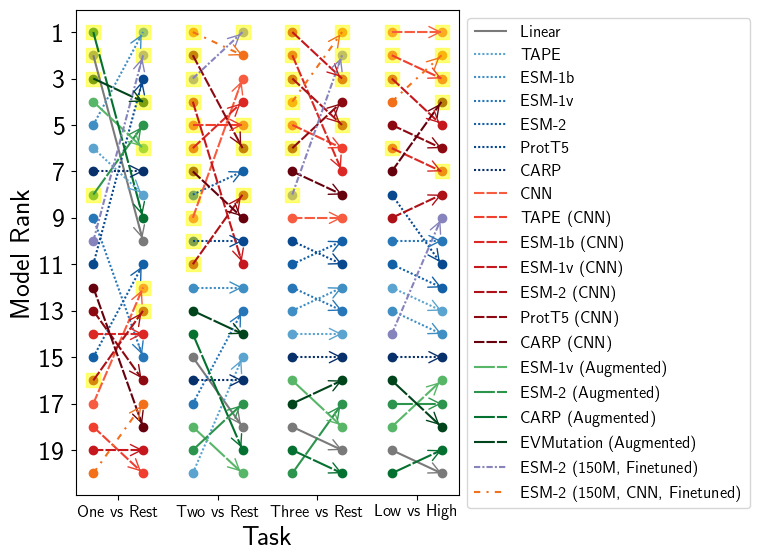

In [8]:
models = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2', 'ProtT5', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (150M, Finetuned)', 'ESM-2 (150M, CNN, Finetuned)']
results_df_mean_combined = results_df_mean_std['mean'].to_frame(name='Weighted MSE').reset_index().pivot(values='Weighted MSE', index='Model', columns='Task').loc[models]
results_df_mean_ranked = results_df_mean_combined.rank(axis=0, ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
tasks = ['One vs Rest', 'Two vs Rest', 'Three vs Rest', 'Low vs High']
classifications = np.array([0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5])
styles = {0: (0, ()), 1: (0, (1, 1)), 2: (0, (5, 1)), 3: (0, (10, 1)), 4: (0, (3, 1, 1, 1)), 5: (0, (3, 3, 1, 3))}
lengths = [len(classifications[classifications == i]) for i in range(6)]
colormap_names = ['Greys', 'Blues', 'Reds', 'Greens', 'Purples', 'Oranges']
colormaps = []
for colormap_name, length in zip(colormap_names, lengths):
    if length == 1:
        colormaps += [mpl.colormaps[colormap_name].resampled(6)(3)]
    else:
        colormaps += [mpl.colormaps[colormap_name].resampled(2*length)(range(length, 2*length))]
colormaps = np.vstack(colormaps)
results_df_combined_sub = results_df_combined.loc[models]
for i, task in enumerate(tasks):
    stat_sigs = (np.array(p_value_min(results_df_combined_sub[task], props='yes')) == 'yes')
    stat_sigs_flighted = (np.array(p_value_min(results_df_combined_sub[task + " FLIGHTED"], props='yes')) == 'yes')
    for model, classification, color, stat_sig, stat_sig_flighted in zip(models, classifications, colormaps, stat_sigs, stat_sigs_flighted):
        result_model_task = results_df_mean_ranked.loc[model][task]
        result_model_task_flighted = results_df_mean_ranked.loc[model][task + ' FLIGHTED']
        if i == 0:
            ax.plot([2*i, 2*i+1], [result_model_task, result_model_task_flighted], c=color, linestyle=styles[classification], label=model)
        else:
            ax.plot([2*i, 2*i+1], [result_model_task, result_model_task_flighted], c=color, linestyle=styles[classification])
        ax.annotate("", xy=(2*i+1, result_model_task_flighted), xytext=(2*i+0.9, 0.9*result_model_task_flighted + 0.1*result_model_task), arrowprops=dict(arrowstyle='->', color=color))
        ax.scatter([2*i, 2*i+1], [result_model_task, result_model_task_flighted], color=color)
        if stat_sig:
            ax.scatter([2*i], [result_model_task], c='yellow', alpha=0.5, s=100, marker='s')
        if stat_sig_flighted:
            ax.scatter([2*i+1], [result_model_task_flighted], c='yellow', alpha=0.5, s=100, marker='s')
ax.set_ylabel('Model Rank')
ax.set_yticks(range(2, len(models) + 1, 2))
ax.set_yticklabels(len(models) + 1 - np.arange(2, len(models) + 1, 2))
ax.set_xlabel('Task')
ax.set_xticks([0.5, 2.5, 4.5, 6.5])
ax.set_xticklabels(tasks, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

/tmp/ipykernel_964311/2008517691.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tasks)


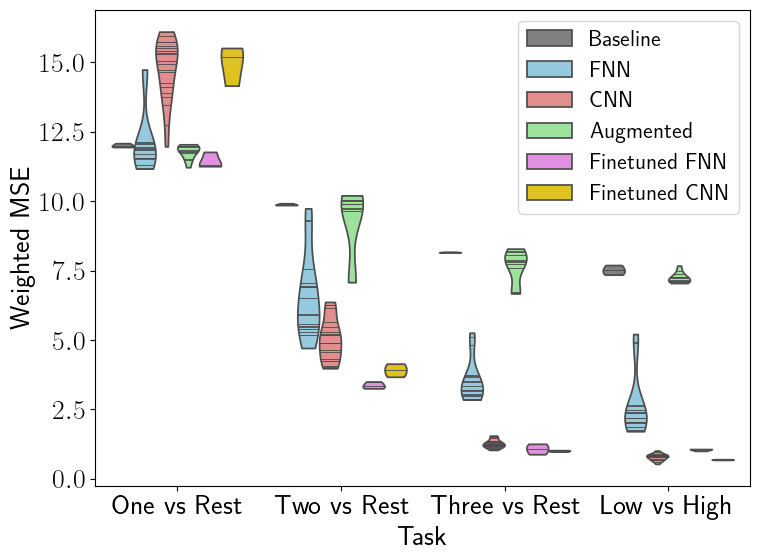

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
results_df_flighted_only = results_df[np.logical_and([val.endswith('FLIGHTED') for val in results_df['Task']], [val in models for val in results_df['Model']])]
sns.violinplot(results_df_flighted_only, x='Task', y='Weighted MSE', hue='Model Type', density_norm='width', hue_order=['Baseline', 'FNN', 'CNN', 'Augmented', 'Finetuned FNN', 'Finetuned CNN'], palette=['grey', 'skyblue', 'lightcoral', 'lightgreen', 'violet', 'gold'], cut=0, inner='stick')
ax.set_xticklabels(tasks)
ax.legend(fontsize=16)
fig.tight_layout()

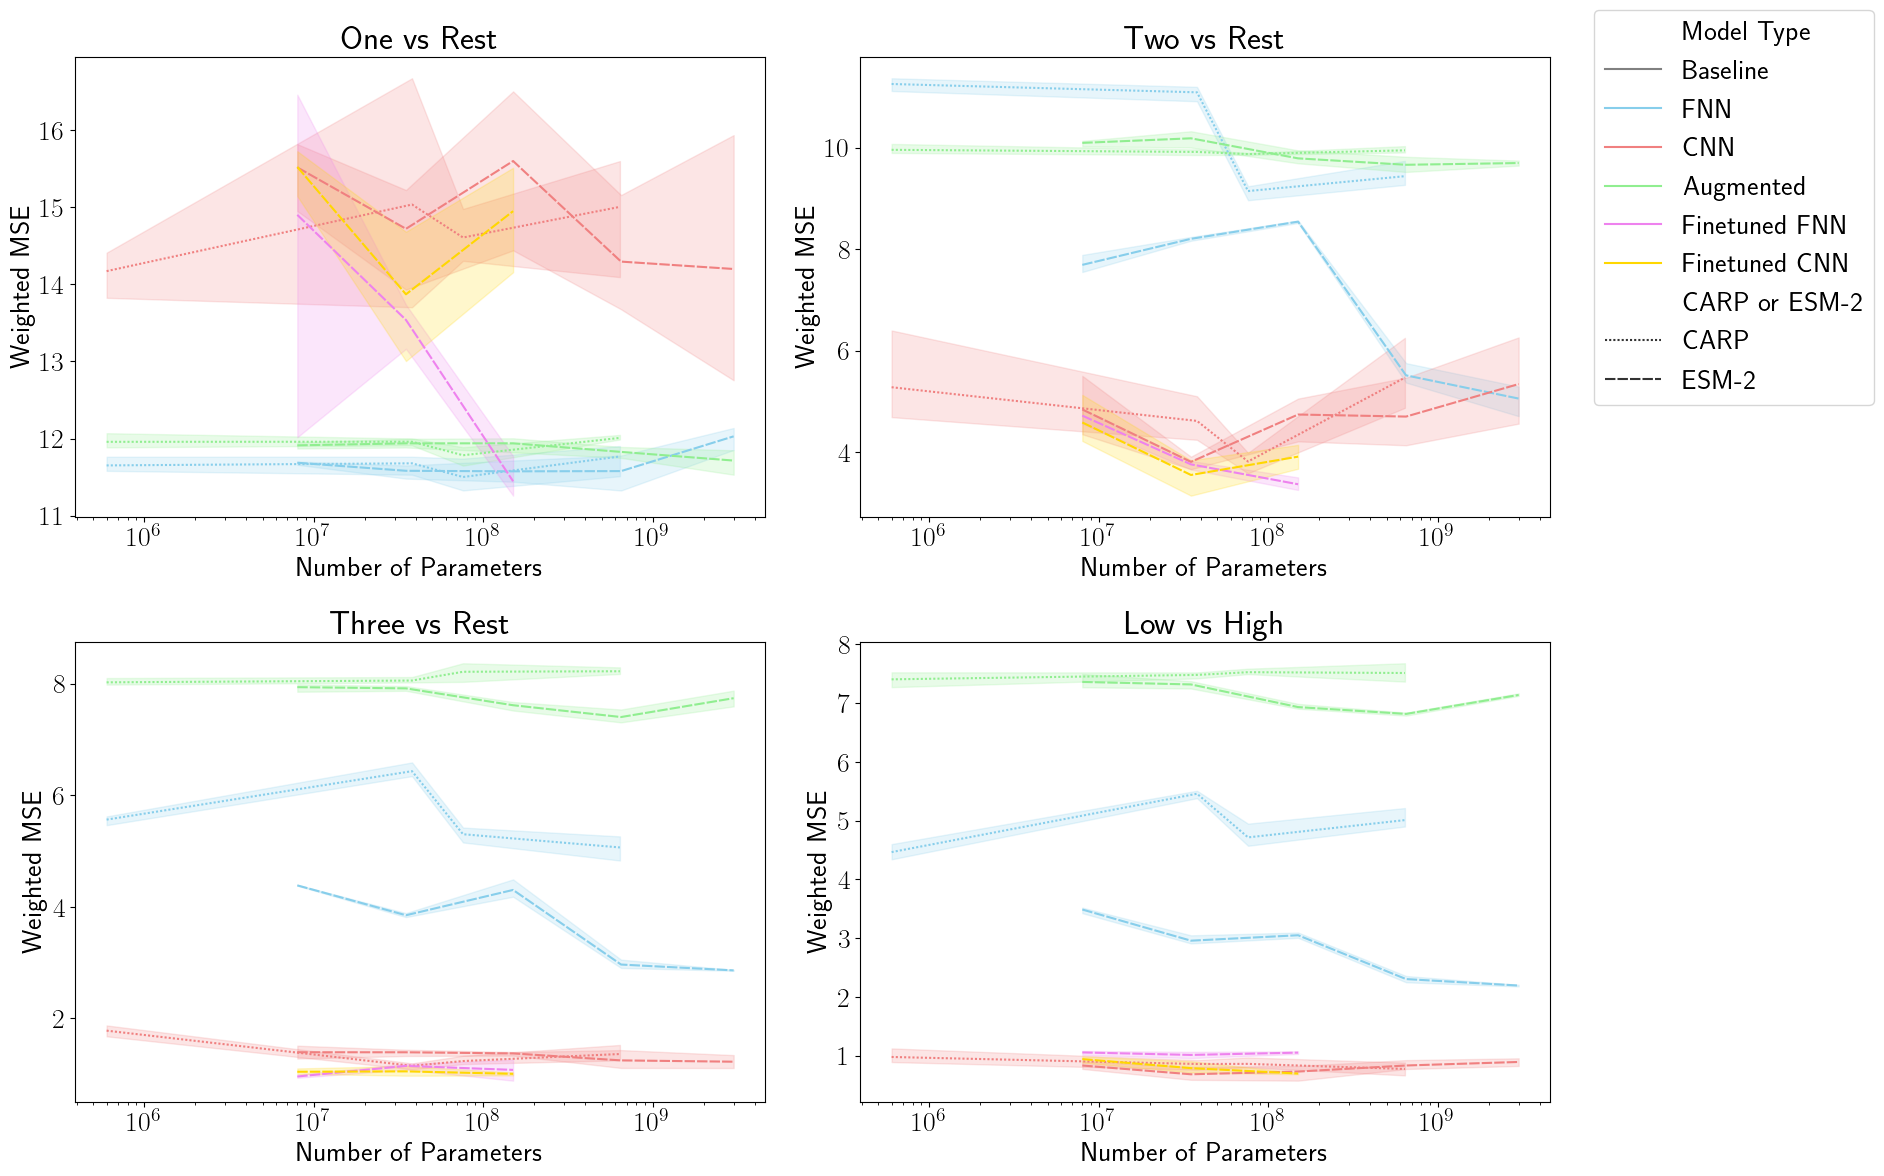

In [10]:
pd.options.mode.chained_assignment = None
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 12))
for i, task in enumerate(tasks):
    j = i%2
    k = int((i - j)/2)
    results_df_sub = results_df[[val == task + ' FLIGHTED' for val in results_df['Task'].values]]
    carp_results_df = results_df_sub[[val.startswith('CARP') for val in results_df_sub['Model'].values]]
    carp_results_df['CARP or ESM-2'] = 'CARP'
    esm2_results_df = results_df_sub[[val.startswith('ESM-2') for val in results_df_sub['Model'].values]]
    esm2_results_df['CARP or ESM-2'] = 'ESM-2'
    results_df_sub = pd.concat([carp_results_df, esm2_results_df])
    sns.lineplot(results_df_sub, x='Number of Parameters', y='Weighted MSE', ax=ax[k][j], style='CARP or ESM-2', hue='Model Type', hue_order=['Baseline', 'FNN', 'CNN', 'Augmented', 'Finetuned FNN', 'Finetuned CNN'], palette=['grey', 'skyblue', 'lightcoral', 'lightgreen', 'violet', 'gold'], dashes = [(1, 1), (5, 1)])
    ax[k][j].semilogx()
    ax[k][j].legend().set_visible(False)
    ax[k][j].set_title(task)
handles, labels = ax[0][0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

/tmp/ipykernel_964311/1079725874.py:3: FutureWarning: ['Model Type'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Spearman R']


One vs Rest
0.01261777777777777
Improved: 10, Deproved: 6, Total: 45
Two vs Rest
0.13480222222222216
Improved: 30, Deproved: 0, Total: 45
Three vs Rest
0.05988888888888899
Improved: 43, Deproved: 0, Total: 45
Low vs High
-0.00794222222222224
Improved: 4, Deproved: 13, Total: 45


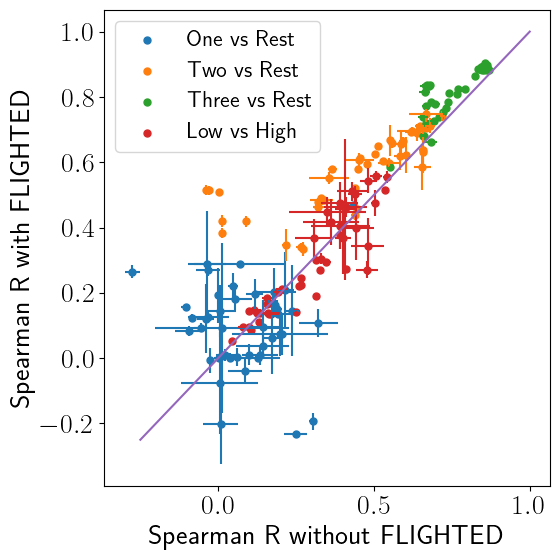

In [13]:
row_order = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2 (8M)', 'ESM-2 (35M)', 'ESM-2 (150M)', 'ESM-2 (650M)', 'ESM-2', 'ProtT5', 'CARP (600k)', 'CARP (38M)', 'CARP (76M)', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (8M, CNN)', 'ESM-2 (35M, CNN)', 'ESM-2 (150M, CNN)', 'ESM-2 (650M, CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (600k, CNN)', 'CARP (38M, CNN)', 'CARP (76M, CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (8M, Augmented)', 'ESM-2 (35M, Augmented)', 'ESM-2 (150M, Augmented)', 'ESM-2 (650M, Augmented)', 'ESM-2 (Augmented)', 'CARP (600k, Augmented)', 'CARP (38M, Augmented)', 'CARP (76M, Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (8M, Finetuned)', 'ESM-2 (35M, Finetuned)', 'ESM-2 (150M, Finetuned)', 'ESM-2 (8M, CNN, Finetuned)', 'ESM-2 (35M, CNN, Finetuned)', 'ESM-2 (150M, CNN, Finetuned)']
column_order = ['One vs Rest', 'One vs Rest FLIGHTED', 'Two vs Rest', 'Two vs Rest FLIGHTED', 'Three vs Rest', 'Three vs Rest FLIGHTED', 'Low vs High', 'Low vs High FLIGHTED']
results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Spearman R']
results_df_mean_std_grouped = results_df_mean_std.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
results_df_combined = results_df_mean_std_grouped.to_frame(name='Spearman R').reset_index().pivot(values='Spearman R', index='Model', columns='Task').reindex(row_order)[column_order]


fig, ax = plt.subplots(figsize=(6, 6))
for task in tasks:
    pre_flighted_vals = [float(val.split('±')[0]) for val in results_df_combined[task].values]
    pre_flighted_errs = [float(val.split('±')[1]) for val in results_df_combined[task].values]
    post_flighted_vals = [float(val.split('±')[0]) for val in results_df_combined[task + ' FLIGHTED'].values]
    post_flighted_errs = [float(val.split('±')[1]) for val in results_df_combined[task + ' FLIGHTED'].values]
    ax.scatter(pre_flighted_vals, post_flighted_vals, label=task, s=25)
    ax.errorbar(pre_flighted_vals, post_flighted_vals, xerr=pre_flighted_errs, yerr=post_flighted_errs, ls='None')
    print(task)
    print(np.mean(post_flighted_vals) - np.mean(pre_flighted_vals))
    t_tests = [stats.ttest_ind_from_stats(mean1, std1, 3, mean2, std2, 3, equal_var=False) for mean1, std1, mean2, std2 in zip(pre_flighted_vals, pre_flighted_errs, post_flighted_vals, post_flighted_errs)]
    improved = np.array([t_test.statistic < 0 and t_test.pvalue < 0.05 for t_test in t_tests])
    deproved = np.array([t_test.statistic > 0 and t_test.pvalue < 0.05 for t_test in t_tests])
    print(f"Improved: {len(improved[improved])}, Deproved: {len(deproved[deproved])}, Total: {len(improved)}")
ax.plot(np.linspace(-0.25, 1), np.linspace(-0.25, 1))
ax.legend(fontsize=16)
ax.set_xlabel('Spearman R without FLIGHTED')
ax.set_ylabel('Spearman R with FLIGHTED')
fig.tight_layout()

/tmp/ipykernel_964311/3053710283.py:3: FutureWarning: ['Model Type'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted Spearman R']


One vs Rest
0.011933333333333337
Improved: 8, Deproved: 5, Total: 45
Two vs Rest
0.14605777777777773
Improved: 36, Deproved: 0, Total: 45
Three vs Rest
0.05121333333333333
Improved: 41, Deproved: 0, Total: 45
Low vs High
-0.002933333333333371
Improved: 4, Deproved: 13, Total: 45


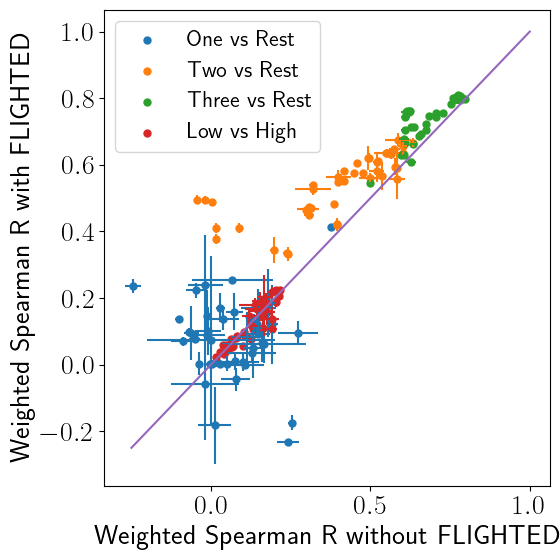

In [14]:
row_order = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2 (8M)', 'ESM-2 (35M)', 'ESM-2 (150M)', 'ESM-2 (650M)', 'ESM-2', 'ProtT5', 'CARP (600k)', 'CARP (38M)', 'CARP (76M)', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (8M, CNN)', 'ESM-2 (35M, CNN)', 'ESM-2 (150M, CNN)', 'ESM-2 (650M, CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (600k, CNN)', 'CARP (38M, CNN)', 'CARP (76M, CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (8M, Augmented)', 'ESM-2 (35M, Augmented)', 'ESM-2 (150M, Augmented)', 'ESM-2 (650M, Augmented)', 'ESM-2 (Augmented)', 'CARP (600k, Augmented)', 'CARP (38M, Augmented)', 'CARP (76M, Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (8M, Finetuned)', 'ESM-2 (35M, Finetuned)', 'ESM-2 (150M, Finetuned)', 'ESM-2 (8M, CNN, Finetuned)', 'ESM-2 (35M, CNN, Finetuned)', 'ESM-2 (150M, CNN, Finetuned)']
column_order = ['One vs Rest', 'One vs Rest FLIGHTED', 'Two vs Rest', 'Two vs Rest FLIGHTED', 'Three vs Rest', 'Three vs Rest FLIGHTED', 'Low vs High', 'Low vs High FLIGHTED']
results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted Spearman R']
results_df_mean_std_grouped = results_df_mean_std.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
results_df_combined = results_df_mean_std_grouped.to_frame(name='Weighted Spearman R').reset_index().pivot(values='Weighted Spearman R', index='Model', columns='Task').reindex(row_order)[column_order]

fig, ax = plt.subplots(figsize=(6, 6))
for task in tasks:
    pre_flighted_vals = [float(val.split('±')[0]) for val in results_df_combined[task].values]
    pre_flighted_errs = [float(val.split('±')[1]) for val in results_df_combined[task].values]
    post_flighted_vals = [float(val.split('±')[0]) for val in results_df_combined[task + ' FLIGHTED'].values]
    post_flighted_errs = [float(val.split('±')[1]) for val in results_df_combined[task + ' FLIGHTED'].values]
    ax.scatter(pre_flighted_vals, post_flighted_vals, label=task, s=25)
    ax.errorbar(pre_flighted_vals, post_flighted_vals, xerr=pre_flighted_errs, yerr=post_flighted_errs, ls='None')
    print(task)
    print(np.mean(post_flighted_vals) - np.mean(pre_flighted_vals))
    t_tests = [stats.ttest_ind_from_stats(mean1, std1, 3, mean2, std2, 3, equal_var=False) for mean1, std1, mean2, std2 in zip(pre_flighted_vals, pre_flighted_errs, post_flighted_vals, post_flighted_errs)]
    improved = np.array([t_test.statistic < 0 and t_test.pvalue < 0.05 for t_test in t_tests])
    deproved = np.array([t_test.statistic > 0 and t_test.pvalue < 0.05 for t_test in t_tests])
    print(f"Improved: {len(improved[improved])}, Deproved: {len(deproved[deproved])}, Total: {len(improved)}")
ax.plot(np.linspace(-0.25, 1), np.linspace(-0.25, 1))
ax.legend(fontsize=16)
ax.set_xlabel('Weighted Spearman R without FLIGHTED')
ax.set_ylabel('Weighted Spearman R with FLIGHTED')
fig.tight_layout()